In [1]:
%matplotlib inline

import matplotlib
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

mpl.rcParams['figure.figsize'] = (20.0, 10.0)

import tifffile

# RICS calculation using off-the-shelf Python libraries

As per [1], the **rics()** function implements equation 3 as a product of $G(\xi,\psi)$ and $S(\xi,\psi)$:

$$\begin{align}
\tau = \tau_p |\xi| + \tau_l |\psi|\\
G(\xi,\psi) = \frac{\gamma}{N} \left(1+\frac{4 D \tau}{w_0^2} \right)^{-1} \times \left(1+\frac{4 D \tau}{w_z^2} \right)^{-1/2} \\
S(\xi,\psi) = exp \left(-\frac{\left(\frac{|\xi|\delta_x}{w_0}\right)^2 + \left(\frac{|\psi|\delta_y}{w_0}\right)^2}{1+\frac{4 D \tau}{w_0^2}}\right) \\
G_S(\xi,\psi) = G(\xi,\psi) \times S(\xi,\psi)
\end{align}$$

This is our **rics()** model function, which we are fitting to the autocorrelation of a 64 x 64 region of interest (roi) using the lmfit library.

The following test images (100nm beads) are provided for testing (the original LIF files were converted to TIFF in FIJI / ImageJ):

**050917 40 nm 4.8us 100nm beads 20 scan v 2.tif** :
https://mega.nz/#!IxFxXSZb!g8oJ9J3TCfKjy8Qj91_Wp_A7G2KVRF0CrxBk7FiUd1k

**050917 40 nm 4.8us 100nm beads 20 scan v3.tif** :
https://mega.nz/#!E59WSRZZ!8wKBpNBpfABLk497enTJ7YCOdYX1gbswSWSCcFxeZfE

## References

[1] Brown, C. M. et al. “Raster Image Correlation Spectroscopy (RICS) for Measuring Fast Protein Dynamics and Concentrations with a Commercial Laser Scanning Confocal Microscope.” Journal of microscopy 229.0 1 (2008): 78–91. PMC. Web. 19 Sept. 2017.

# Helper functions

In [2]:
import ezvis3d as v3d
import pandas as pd

def plot_3d(data):
    roi_size = roi.shape[0]

    li_data =[]
    for y in range(roi_size):
        for x in range(roi_size):
            li_data.append({'x':x-roi_size/2, 'y':y-roi_size/2, 'z':data[y,x]})

    df_data = pd.DataFrame(li_data)

    g = v3d.Vis3d()
    g.width = '800px'
    g.height = '700px'
    g.style = 'surface'
    g.showPerspective = True
    g.showGrid = True
    g.showShadow = False
    g.keepAspectRatio = True
    g.verticalRatio = 0.7
    g.cameraPosition = {'horizontal' : 0.6,
                        'vertical': -0.1,
                        'distance': 1.6
                       }

    return g,df_data

Open console to check js libs were loaded in page


In [3]:
def clean_tags(tags,fname):
    if not " - " in fname:
        return tags
    ser = fname.split(" - ")[1].replace(".tif","")
    #Now, do we have ser in any of the tags?
    has_ser = False
    for tag in tags:
        if ser in tag:
            has_ser = True
            break
    if not has_ser:
        return tags

    new_tags = []
    ser = ser + " "
    for tag in tags:
        if ser in tag:
            tag = tag.replace(ser,"")
            new_tags.append(tag)
            
    return new_tags

def getSeriesMetadataValue(tags,key):
    value = None
    for t in tags:
        if key in t:
            value = float(t.split(" = ")[1])
            break
    return value

In [4]:
#Generate grid indexes and optionally remove the (0,0) point
def generate_grid(xmin,xmax,ymin,ymax,remove_zero = True):
    X = []
    Y = []
    for y in range(ymin,ymax):
        for x in range(xmin,xmax):
            if remove_zero and x == 0 and y == 0:
                continue
            X.append(x)
            Y.append(y)
    return np.array(X),np.array(Y)
            

In [5]:
# 2-D Correlation methods (numpy fft)
import numpy.fft as fft

def autocorr(roi):
    ny,nx = roi.shape
    corr = fft.fftshift(np.real(fft.ifft2(fft.fft2(roi.astype('d'))*np.conj(fft.fft2(roi.astype('d'))))))/(np.mean(roi)**2*nx*ny) - 1
    return corr

def crosscorr(roi1,roi2):
    ny,nx = roi1.shape
    corr = fft.fftshift(np.real(fft.ifft2(fft.fft2(roi1.astype('d'))*np.conj(fft.fft2(roi2.astype('d'))))))/(np.mean(roi1)*np.mean(roi2)*nx*ny) - 1
    return corr

# Load the image and extract the pixel size / dwell time / line time / frame time

In [6]:
#fn = "050917 40 nm 4.8us 100nm beads 20 scan v 2.tif"
fn = "050917 40 nm 4.8us 100nm beads 20 scan v3.tif"

#Load the image stack using tifffile
tif = tifffile.TiffFile(fn)

In [7]:
#We only need the first frame in the stack
frame = tif.asarray()[0]

#Find the pixel resolution
s,ss = tif[0].x_resolution
pixel_size_um = float(ss) / float(s)

#Find the image size
ny,nx = frame.shape

#Find frame time, line time, pixel dwell time
tags = tif[0].imagej_tags["info"].split("\n")
tags = clean_tags(tags,fn)
frame_time = getSeriesMetadataValue(tags, "FrameTime")
line_time = getSeriesMetadataValue(tags, "LineTime")
pixel_time = getSeriesMetadataValue(tags, "PixelDwellTime")

print "Image size=(%d,%d)" % (nx,ny)
print "Pixel size=%.4fum" % (pixel_size_um)
print "Pixel dwell time=%.4fus" % (pixel_time * 1e6)
print "Line time=%.4fms" % (line_time *1e3)
print "Frame time=%.4fs" % frame_time

Image size=(512,512)
Pixel size=0.0398um
Pixel dwell time=4.8750us
Line time=10.0000ms
Frame time=5.1600s


# Choose a random point in the image

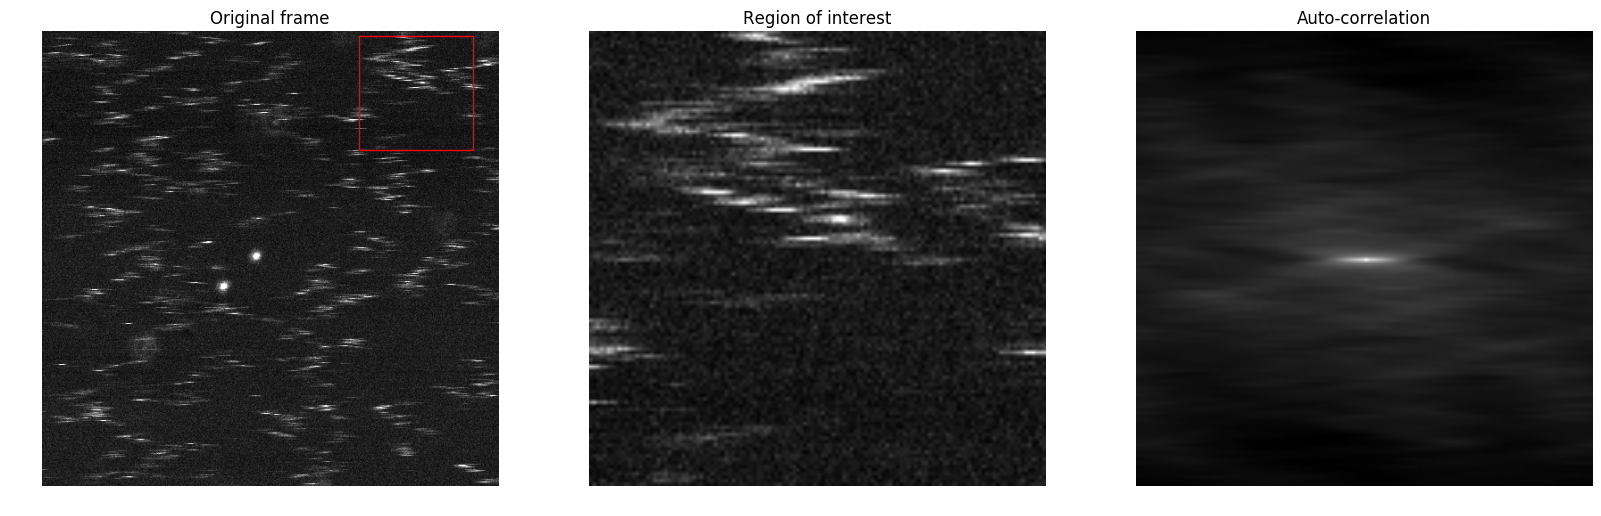

In [8]:
#A random point
x,y = 420,70
roi_size = 128
roi = frame[y-roi_size/2:y+roi_size/2,x-roi_size/2:x+roi_size/2]
corr = autocorr(roi)

fig, (ax_orig, ax_roi, ax_corr) = plt.subplots(1, 3)

ax_orig.imshow(frame, cmap='gray')
ax_orig.set_title('Original frame')
ax_orig.add_patch(Rectangle((x-roi_size/2, y-roi_size/2), roi_size, roi_size, facecolor='none',edgecolor='red'))
ax_orig.set_axis_off()

ax_roi.imshow(roi, cmap='gray')
ax_roi.set_title('Region of interest')
ax_roi.set_axis_off()

ax_corr.imshow(corr, cmap='gray')
ax_corr.set_title('Auto-correlation')
ax_corr.set_axis_off()

# Fitting with LMFit

In [9]:
pixel_size = pixel_size_um * 1e-6

#What are we trying to fit?
def rics(X,Y, g0=0.1, D=1e-12, w0=.23e-6, a=5):
    txpty = pixel_time*np.abs(X)+line_time*np.abs(Y)
    wz = a*w0
    G = g0*np.power(( 1 + 4*D*txpty/w0/w0 ),-1)*np.power(( 1 + 4*D*txpty/wz/wz ),-0.5)
    S = np.exp(- ( np.power((np.abs(X)*pixel_size/w0),2) + np.power((np.abs(Y)*pixel_size/w0 ),2))/( 1 + 4*D*txpty/w0/w0 ) )
    return (G * S).ravel()

In [10]:
from lmfit import Model, Parameters

xmax = roi_size/2
ymax = 5

#Generate an appropriate grid
X1,Y1 = generate_grid(0,xmax,0,ymax,remove_zero=True)
data = corr[roi_size/2:roi_size/2+ymax,roi_size/2:roi_size/2+xmax].ravel()[1:]

gmodel = Model(rics, independent_vars=['X', 'Y'])

pars = Parameters()
pars.add('g0', value=0.1, min=0, max=1)
pars.add('D', value=1e-8, min=1e-13, max=1e-5)
pars.add('w0', value=.23e-6, min=.1e-6, max=.9e-6)
pars.add('a', value=5, min=1, max=6)

result = gmodel.fit(data, X=X1, Y=Y1, params=pars)
#comps = result.eval_components()
g0_ = result.params['g0'].value
D_ = result.params['D'].value
w0_ = result.params['w0'].value
a_ = result.params['a'].value

print(result.fit_report())

k = 1.3807e-23
T = 298.15
v = 8.9e-4
r = k*T/6./np.pi/v/D_
print("Hydrodynamic radius (t=25C) %fnm" % (r*1e9))

gamma = 1./np.sqrt(8)
N = gamma / g0_

print("g0=%.2e" % g0_)
print("D=%.2ecm^2/s" % (D_*1e2*1e2))
print("w0=%.2e" % w0_)
print("a=%.1f" % a_)

[[Model]]
    Model(rics)
[[Fit Statistics]]
    # function evals   = 154
    # data points      = 319
    # variables        = 4
    chi-square         = 0.103
    reduced chi-square = 0.000
    Akaike info crit   = -2556.153
    Bayesian info crit = -2541.093
[[Variables]]
    g0:   0.44758000 +/- 0.008835 (1.97%) (init= 0.1)
    D:    4.3004e-12 +/- 3.02e-13 (7.03%) (init= 1e-08)
    w0:   4.4361e-07 +/- 8.97e-09 (2.02%) (init= 2.3e-07)
    a:    5.99999679 +/- 5.028498 (83.81%) (init= 5)
[[Correlations]] (unreported correlations are <  0.100)
    C(D, a)                      =  0.763 
    C(g0, w0)                    = -0.655 
    C(w0, a)                     = -0.509 
    C(g0, D)                     =  0.260 
    C(g0, a)                     =  0.211 
    C(D, w0)                     = -0.158 

Hydrodynamic radius (t=25C) 57.060651nm
g0=4.48e-01
D=4.30e-08cm^2/s
w0=4.44e-07
a=6.0


# Display the autocorrelation / fit along the X and Y axis

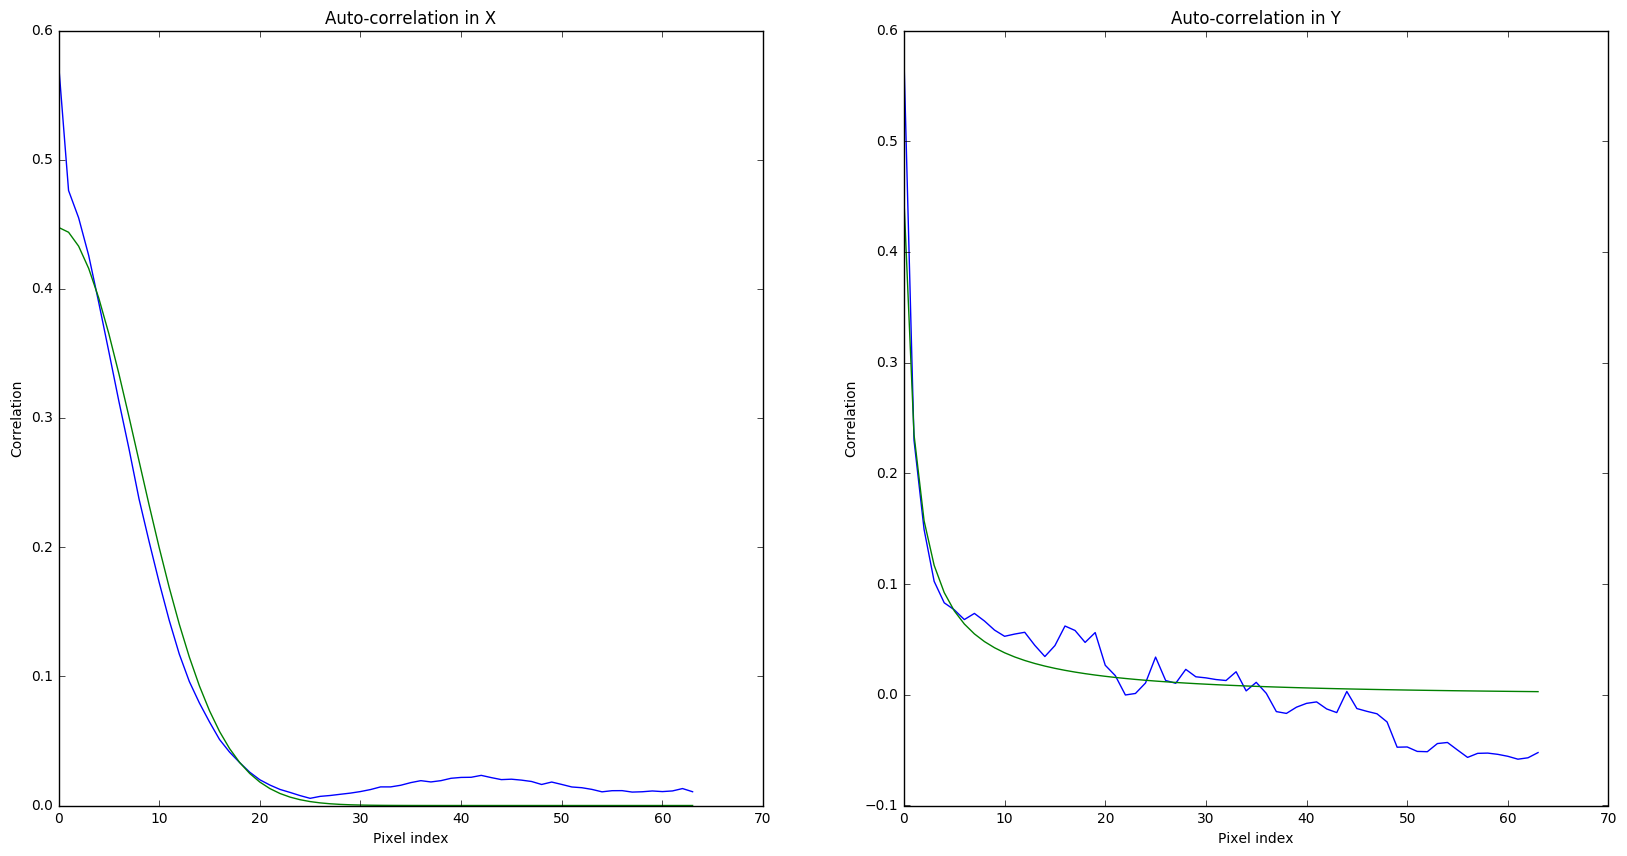

In [11]:
X = np.arange(0,roi_size)-roi_size/2
Y = np.arange(0,roi_size)-roi_size/2
X, Y = np.meshgrid(X, Y)

fit = result.eval(X=X, Y=Y).reshape(roi_size,roi_size)
#print params

#fit = rics((X,Y),*popt).reshape(roi_size,roi_size)

fig, (ax_corrx, ax_corry) = plt.subplots(1, 2)

xr = np.arange(roi_size/2)

ax_corrx.plot(xr,corr[roi_size/2,roi_size/2:])
ax_corrx.plot(xr,fit[roi_size/2,roi_size/2:])
ax_corrx.set_title('Auto-correlation in X')
ax_corrx.set_xlabel('Pixel index')
ax_corrx.set_ylabel('Correlation')

ax_corry.plot(xr,corr[roi_size/2:,roi_size/2])
ax_corry.plot(xr,fit[roi_size/2:,roi_size/2])
ax_corry.set_title('Auto-correlation in Y')
ax_corry.set_xlabel('Pixel index')
ax_corry.set_ylabel('Correlation')


# Auto-correlation data / fit as interactive surface maps

In [12]:
g, df_data = plot_3d(corr)
g.plot(df_data, save=True)

In [13]:
g, df_data = plot_3d(fit)
g.plot(df_data, save=True)

In [14]:
residual = corr - fit

g, df_data = plot_3d(residual)
g.plot(df_data, save=True)